# TOP
Notes from prof:
- TimeSeriesSplit
- Label analysis
  - Labels do not correlate directly to profits at the moment, getting a label that better correlates would be good
  - Continue with our current labels for now but just note that we should go back and change them later on. Just put some thought into the implications of both log returns and our current labels.
- Simple RL
  - Use Supervised outputs as inputs for RL state-action value function
  - Try to use a policy-gradient method
- Edit the performance function to include long_only=True

- Thinking about the car and hill problem, RL gives our model a long sequence of actions (policy / strategy) to play the game right and win overall. Likewise, in financial trading, RL can give us the best set of actions to take to maximize returns. But for my original idea, RL can also be used to decide how best to detect signals. Learn both to detect signals and how to play the game right.  Two RL steps in one.  

- Slide 41 of 56 from this set of lecture slides would be good for our purposes https://www.davidsilver.uk/wp-content/uploads/2020/03/FA.pdf

In [1]:
import os
import pathlib
from datetime import datetime, time, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import torch

from torch import nn
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


from scipy.optimize import minimize_scalar

import LOB_analysis

%matplotlib inline

## Plan
- Try lowering the trading frequency by increasing the time horizon of the labeller (Less noise in the signal but more in the input data)
- Try raising the trading frequency by lowering the time horizon of the labeller (More noise in the signal but less in the input data)
- Toggle standardization
- Toggle reindexing with forward padding
- Iterate over different granularities



### Performance metrics
We dont always have data for every interval (i.e. some intervals are missing. Should we try to reindex the data and stall the model when theres no data?
- Mid-price prediction (without bid-ask spread and trading fees)
- Number of trades executed
- Time of trades
- Raw profit (Account for bid-ask spread but not trading fee, that can be computed at the end)
- Cumulative profits
- Trading fee (Number of trades x cost of each trade)
- Usefulness of features [Simple models allow this]
- During training, monitor the training and validation loss to monitor for overfitting


### Simple model
1. Find the ideal time interval (Full search)
2. Evaluate Curse of Dimensionality (Full search)
3. Given optimal time interval and Curse of Dimensionality, evaluate hyperparameter tuning at different times of the day

- Vary hyperparameters at different times of the day (Proving that different hyperparameters are needed at different times of day would prove the importance of retraining the complex model)
- Using a feature selector model like lasso across different time periods could show if features change in importance
- Try to train models that adhere to the following 2 principles:
  - Granularity: Signals have different time intervals - Must be able to narrow in on the time interval needed, out of a large given input
  - Non-stationarity: Weights need to be updated *quickly* and *responsively*

- Do anchored walk-forward by sample. Evaluate intraday performance.
- Evaluate the usefulness of features
- Perform hyperparameter tuning
- Finding the right granularity to trade at is something only the simple model needs, the complex model just has to ensure that at its peak, inception allows for large enough views of the data
- During training, monitor the training and validation loss to monitor for overfitting

Consider various non-NN approaches including SVMs, LDA, QDA, MLP, or the linear approaches like LR, MLR, Lasso, Ridge, Elastic. Try trees too.

Apparently SVM does structural risk minimization as opposed to empiricial risk minimization - some paper.


### RL based on simple model

Try to create an agent that mimics what the complex model would do. This gives a baseline to compare the complex model to.


### Complex model
- Transitory signals: RL agent uses a "Critic" NN to evaluate if/which layers of the Actor NN should be retrained.
What are we using as labels to decide whether to retrain or not?  
If we get the RL agent to decide on retraining, will this be an exponentially slow process?  
Is the focus on Signal and retraining when Signal becomes weak?  
Is this an RL Action or Architecture problem?  

- Non-stationary signals: Need to train *quickly* in an online fashion. Use forward propagation otherwise learning might be too slow.
- Detect signals at different time-interval granularities: Inception layers

- Retraining of specific layers decided by some NN:
  - Upper-most layers: Tune highest level features to make decisions on
  - Inception layers: Change the granularity we focus on
  - Starting layers: We can let the NN decide and analyse if these are ever good options
  Track these tuning decisions as metrics from the agent / model  
  
  - Penalties for retraining (*or some weighted average of the below*). Note that penalties are needed or the model could perpetually train to avoid making any trades or losses:
    - Perfect trading during the trading period - This would correlate strongly with volatility, since perfect trading in a quickly moving market would result in greater profits
    - Continuing the current trading strategy during the trading period (*** THIS IS VERY IMPORTANT SINCE IF THE CURRENT TRADING STRATEGY WOULD HAVE LOST MONEY, THIS COST WOULD BE NEGATIVE - A REWARD, WHICH IS WHAT WE WANT)
    - Flat cost penalty for retraining - should not be so large that it starves the model of retraining opportunities
  - Do we want to let the RL agent decide how many samples it needs to retrain? (For now, no)
  - Retraining takes time, so this is one type of action that actually takes quite long to complete. But by progressing the time of the dataset, we'll actually always take the same duration to iterate over the same number of samples.
    - We might want to augment the data across epochs so that the training process isnt just repeated each epoch
  

Retraining will take time and cause missed trading opportunities.  
We have to decidie whether we want to hold our positions or close them.  
I think that in the absence of more information we should always exit the market.  

- Experience replay is usually needed for training NN-based RL models, figure out how to do this with timeseries data
- To have a stateful model, we should consider an RNN architecture (Transformers and self-attention first for parallelization: Find some way to include time for transformers)
- For labels of Actor model it should supply the raw classification scores (rather than the labels) onwards, so that the critic can decide whether to retrain
- We might want to penalise not trading with some interval dependent cost of capital (Not now)
- In the absence of signals we should always be perfectly market neutral, i.e. we should exit the market
- Using some epislon-greedy approach to retraining is quite impractical because of the huge amount of time itll take to randomly retrain / buy / sell. Perhaps by having some constrained (short and thin) NN or by using progressing time samples, even during retraining, we'll be able to improve. But progressing time samples allows the epoch to be completed, it doesnt actually increase the learning points that the RL agent experiences. We might need to start it off with some sensible strategy, like train the actor once through to have some overall baseline, then for the critic model, try various retraining points. Could try alternatively and iteratively training only actor model, then critic model, then actor model given the critic model (frozen) then critic model given the actor model (frozen)? [Not now, see if conventional training works. Will need to understand if this approach even converges. Need to reframe this very problem as RL's iterative learning].
- During training, monitor the training and validation loss to monitor for overfitting


### Post analysis
- Check if there are conditions (e.g. time, volatility) that specifically impact model performance
- Frequency that each actor NN layer is retrained
- Conditions whereby an actor NN layer is retrained
- Impact of actor NN layer retraining
- Use a debugging dataset of maybe 1 or 3 days and manually look through to see if:
  - There are features to improve
  - Time-of-day issues
  - Hyper parameters that perform better/worse under conditions
  - Action-space needs to include more actions
  
- At a more general level, we'd want to evaluate where RL lands on the Chess to Customer Service spectrum of technology. We need to understand the circumstances under which RL is effective at trading and when it is not.

## 1. Load Data

Each transaction has: 
1. a time stamp (when transaction occured) expressed in seconds since midnight
2. type of transactions:
        Event Type:
        1: Submission of a new limit order
        2: Cancellation (partial deletion of a limit order)
        3: Deletion (total deletion of a limit order)
        4: Execution of a visible limit order
        5: Execution of a hidden limit order
        6: Indicates a cross trade, e.g. auction trade
        7: Trading halt indicator (detailed information below)
3. the Id of the transaction
4. volume (how many stocks were transacted) and at what price
5. direction:  
        +1: indicats: BUY order // seller initiated trade (a seller takes the initiative to consume some of the quoted offers at the BID// The volume at the BID decreases 
        -1: indicates: SELL order // buyer initiated trade (a buyer takes the initiative to consume some of the quoted offers at the ASK// The volume at the ASK decreases 
**CAREFUL: Execution of a sell (buy) limit order corresponds to a buyer (seller) initiated trade, i.e. buy (sell) trade.**  


see: https://lobsterdata.com/info/DataStructure.php

In [2]:
message = pd.read_pickle(r"../data/AMD_jan_msg.pickle")
orderbook = pd.read_pickle(r"../data/AMD_jan_odb.pickle")

In [3]:
MARKET_OPEN = '9:30'
MARKET_CLOSE = '16:00'

market_open_idx = message.set_index('time').index.indexer_between_time(MARKET_OPEN, MARKET_CLOSE)

message = message.iloc[market_open_idx, :].reset_index(drop=True)
orderbook = orderbook.iloc[market_open_idx, :].reset_index(drop=True)

## 2. Study time intervals [Not a priority]

#### Distribution of timings between market orders

Check various time intervals (milli | half-second | second | minute) for differences in how trades are distributed:
- Buy/sell lag
- Time variations
- Quantity variations [Group-by the time interval, (sum | average | VWAP) the quantity, then evaluate its histogram, variance, normality]
- Volume variations
- Normalized mid-price variation
- Volume imbalances
- When grouped by interval, do prices have a distribution? (Symmetry?) -> Hypothesis is that the smaller the time window, the more noise we should encounter and hence the mid-price should be normally distributed

Do a cross-sectional check across time-of-day and day-of-week
- Quantities of trades that occur throughout the time period
- Count of buy trades vs sell trades
- Check each time zone, i.e. for differences < 1 (milli|s|minute) second how are trades distributed for buy/sell. Do a study on the number of trades that occur at each time point during a day, throughout the week, throughout the year and so on. We want to know how many events occur in each time interval window, how many of these are buy/sell events? How are the prices distributed in each window? Are they symmetrical, normally distributed?

Observations:
- At an aggregated level, there seems to be more trading activity at the start and end of the trading day.



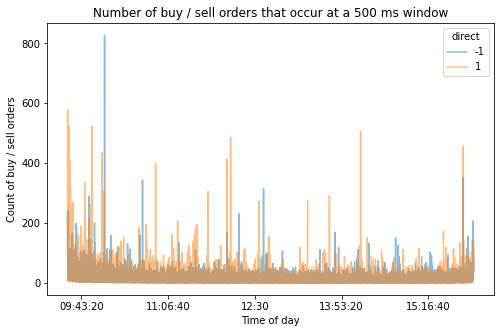

In [4]:
time_interval = "500 ms"
combined = pd.concat([message, orderbook], axis=1)
combined.direct.groupby(combined.time.dt.round(f"{time_interval}").dt.time).value_counts().unstack().plot(figsize=(8, 5), alpha=0.5)
plt.xlabel("Time of day")
plt.ylabel("Count of buy / sell orders")
plt.title(f"Number of buy / sell orders that occur at a {time_interval} window");
print("""\
Observations:
- At an aggregated level, there seems to be more trading activity at the start and end of the trading day.
""")

## 3. Create features

**I do not know if standardization is actually a good thing. [CHECK - Ask prof too]**  
Standardization will be done using a small window of previous events. This is because the statistical properties change as time moves on, so we standardize w.r.t small prior windows. Standardization benefits ML training since values will stradle 0 and not be too far from it.  

**Check if we should reindex time-series data with forward padding and explicitly 0-labels given to these regions.**

**BE CAREFUL OF THE CURSE OF DIMENSIONALITY**
To understand if the curse of dimensionality is affecting performance, rerun the exact same experiments with fewer features and see if profitability increases.


### Base features
---
- Bid price
- Ask price
- Mid price
- Generate 2 additional mid-prices, mid-price of level 2, and mid-price of level 3
- Past return $\ln(\frac{S_t}{S_{t-\delta t}})$ (Mean reversion and momentum effects)
- Order book imbalance: $\ln(\frac{Liq_{bid}}{Liq_{ask}})$, $Liq_{bid} = \sum_{i \in Levels} w_i |b_i| P_i^B$, where $w_i$ is a positive decreasing function of $i$, $P_i^B$ is the price at limit $i$ on the bid (ask) side, and $b_i$ is the volume at that price
- Weighted Total Volume (On both sides)

In [5]:
def get_base_features(message, orderbook, weights = [0.7, 0.2, 0.05, 0.03, 0.02]):
    data = message.drop(['id'], axis=1).copy()
    
    data.loc[:, 'bid'] = orderbook.bid_price_1
    data.loc[:, 'ask'] = orderbook.ask_price_1
    data.loc[:, 'spread'] = data.ask - data.bid
    data.loc[:, 'mid_price'] = (data.ask + data.bid) / 2
    data.loc[:, 'mid_price_2'] = (orderbook.ask_price_2 + orderbook.bid_price_2) / 2
    data.loc[:, 'mid_price_3'] = (orderbook.ask_price_3 + orderbook.bid_price_3) / 2
    data.loc[:, 'log_return'] = np.log(data.mid_price) - np.log(data.mid_price).shift(1)
    
    # Order book imbalance
    data.loc[:, 'weighted_ask_liquidity'] = 0
    data.loc[:, 'weighted_buy_liquidity'] = 0
    weights = [0.7, 0.2, 0.05, 0.03, 0.02]
    for i in range(1, len(weights) + 1):
        data.loc[:, 'weighted_ask_liquidity'] += orderbook.loc[:, f'ask_price_{i}'] * orderbook.loc[:, f'ask_size_{i}'] * weights[i-1]
        data.loc[:, 'weighted_buy_liquidity'] += orderbook.loc[:, f'bid_price_{i}'] * orderbook.loc[:, f'bid_size_{i}'] * weights[i-1]
    data.loc[:, 'weighted_ask_liquidity'] = data.loc[:, 'weighted_ask_liquidity'].replace(0, np.nan)
    data.loc[:, 'order_book_imbalance'] = np.log(data.loc[:, 'weighted_buy_liquidity']) - np.log(data.loc[:, 'weighted_ask_liquidity'])
    
    # Weighted total volume
    data.loc[:, 'weighted_ask_volume'] = 0
    data.loc[:, 'weighted_buy_volume'] = 0
    for i in range(1, len(weights) + 1):
        data.loc[:, 'weighted_ask_volume'] += orderbook.loc[:, f'ask_size_{i}'] * weights[i-1]
        data.loc[:, 'weighted_buy_volume'] += orderbook.loc[:, f'bid_size_{i}'] * weights[i-1]
    
    return data.reset_index(drop=True)

### Interval insight features
---
- Count of events in the time interval
- Count of buy events in the time interval
- OHLC
- Mid-price volatility
- Volume Weighted Average Price
- Flow quantity: $\ln(\frac{Q_b}{Q_s})$, where $Q_b$ is the sum of all quantities bought (sold) over the last period $\delta t$
- Variance: Log Return, OBI, Volume, Spread, ~Volatility, Flow Quantity~ [These are aggregate values, only 1 number present, cannot get variance]
- ~Min/max: Log Return, OBI, Flow Quantity, Volatility, Volume, Spread~


In [6]:
def get_interval_insight_features(base_data, granularity = '250 ms'):
    base_group = base_data.groupby(base_data.time.dt.round(granularity))
    
    # Data for start-of-period
    interval_data = base_group.first().loc[:, ['bid', 'ask', 'spread', 'mid_price', 'mid_price_2', 'mid_price_3']]
    
    # Aggregate data
    interval_data = interval_data.merge(base_group.agg({
        'vol': np.sum,
        'log_return': np.sum,
        'weighted_ask_liquidity': np.mean,
        'weighted_buy_liquidity': np.mean,
        'order_book_imbalance': np.mean,
        'weighted_ask_volume': np.mean,
        'weighted_buy_volume': np.mean,
    }), left_index=True, right_index=True)
    
    # Counts
    interval_data = interval_data.merge(base_group.size().fillna(0).rename('interval_count'), left_index=True, right_index=True)
    interval_data = interval_data.merge(base_group.direct.value_counts().unstack().rename(columns = {-1: 'interval_sell_count', 1: 'interval_buy_count'}).loc[:, 'interval_buy_count'].fillna(0).rename('interval_buy_count'),
                        left_index=True,
                        right_index=True)
    # OHLC, STD
    interval_data = interval_data.merge(base_group.mid_price.agg([
            lambda x: x.iloc[0],   # Open
            np.max,                # High
            np.min,                # Low
            lambda x: x.iloc[-1],  # Close
            np.std,                # Std
        ]).rename({'<lambda_0>': 'open', 'amax': 'high', 'amin': 'low', '<lambda_1>': 'close', 'std': 'mid_price_std'}, axis=1).fillna(0), left_index=True, right_index=True)
    
    # Volume Weighted Average Price
    vwap = ((base_data.price * base_data.vol).groupby(base_data.time.dt.round(granularity)).sum() / base_data.vol.groupby(base_data.time.dt.round(granularity)).sum()).rename('vwap')
    interval_data = interval_data.merge(vwap, left_index=True, right_index=True)
    
    # Flow Quantity
    flow_qty = base_data.vol.groupby([base_data.time.dt.round(granularity), base_data.direct]).sum().unstack().fillna(1).apply(np.log).loc[:, [-1, 1]].diff(axis=1).loc[:, 1].rename('flow_qty')
    interval_data = interval_data.merge(flow_qty, left_index=True, right_index=True)
    
    # Standard deviation
    std = base_group.std().loc[:, ['spread', 'log_return', 'weighted_ask_liquidity', 'weighted_buy_liquidity', 'order_book_imbalance', 'weighted_ask_volume', 'weighted_buy_volume']].copy().fillna(0).add_suffix("_std")
    interval_data = interval_data.merge(std, left_index=True, right_index=True)
    
    return interval_data

### Interval features
---
- Price Momentum (Today - 10 intervals prior)
- Williams %R (Highest high - current) / (Highest high - lowest low)
- Signal line of MACD, MACD = Fast MA - Slow MA, Signal line = MovingAverage(MACD)
- Price volume trend [(close - yesterdays close) / yesterdays close] * volume + yesterdays PVT
- ROC [Velocity, Acceleration]: Spread, Mid-price, Log Return, OBI, Flow Quantity, Volatility, Volume


In [7]:
def calc_momentum(interval_data, shift=10):
    momentum = (interval_data.mid_price - interval_data.mid_price.shift(shift)).rename(f'mid_price_momentum_{shift}')
    return momentum

def calc_williams_pct_r(interval_data, interval=14):
    mid_price_roll = interval_data.mid_price.rolling(interval)
    williams_pct_r = -100 * ((mid_price_roll.max() - interval_data.mid_price) / (mid_price_roll.max() - mid_price_roll.min())).rename('williams_pct_r')
    return williams_pct_r.fillna(-50) # NAs are introduced when dividing by 0, treat these as middle values from Williams %R range of [-100, 0]

def calculate_macd_signal(interval_data, fast_ma=12, slow_ma=26, signal_ma=10):
    macd = (interval_data.mid_price.ewm(fast_ma).mean() - interval_data.mid_price.ewm(slow_ma).mean()).rename('macd')
    signal_line = macd.rolling(signal_ma).mean().rename('signal_line')
    return macd.to_frame().merge(signal_line, left_index=True, right_index=True)

def calculate_pvt(interval_data):
    pvt = (((interval_data.close - interval_data.close.shift(1)) / interval_data.close.shift(1)) * interval_data.vol).cumsum().rename('pvt')
    return pvt

def get_interval_features(interval_data):
    interval_data = interval_data.merge(calc_momentum(interval_data), left_index=True, right_index=True)
    interval_data = interval_data.merge(calc_williams_pct_r(interval_data), left_index=True, right_index=True)
    interval_data = interval_data.merge(calculate_macd_signal(interval_data), left_index=True, right_index=True)
    interval_data = interval_data.merge(calculate_pvt(interval_data), left_index=True, right_index=True)
    
    roc_columns = ['spread', 'mid_price', 'log_return', 'weighted_ask_liquidity', 'weighted_buy_liquidity', 'order_book_imbalance', 'flow_qty', 'mid_price_std', 'weighted_ask_volume', 'weighted_buy_volume']
    
    # Rate of change: Velocity
    position = interval_data.loc[:, roc_columns].copy().add_suffix("_unit_per_s")
    time = pd.Series(position.index, index=position.index)
    seconds = (time - time.shift(1)).dt.total_seconds()
    displacement = position - position.shift(1)
    velocity = displacement.div(seconds, axis=0)
    interval_data = interval_data.merge(velocity, left_index=True, right_index=True)
    
    # Rate of change: Acceleration
    velocity = velocity.copy().add_suffix("_per_s")
    time = pd.Series(velocity.index, index=velocity.index)
    seconds = (time - time.shift(1)).dt.total_seconds()
    velocity_diff = velocity - velocity.shift(1)
    acceleration = velocity_diff.div(seconds, axis=0)
    interval_data = interval_data.merge(acceleration, left_index=True, right_index=True)
    
    return interval_data

### [Optional] Reindex interval data

If we want to reindex the interval data so that we have data at regular intervals, do so before generating time features

### Time features
---
- XYZ since market open
- Day-of-week
- Week-of-year
- Month


In [8]:
"""
Assumes that all the data provided occurs after the market open.
Discards data outside of market hours.
"""
def get_time_features(interval_data):
    interval_data = interval_data.between_time(MARKET_OPEN, MARKET_CLOSE)
    idx = pd.Series(interval_data.index)
    interval_data = interval_data.reset_index(drop=True)
    
    # Seconds since Market Open
    seconds_since_MO = ((idx - pd.Timedelta(hours=int(MARKET_OPEN.split(':')[0]), minutes=int(MARKET_OPEN.split(':')[1]))).dt.time).apply(
        lambda x: timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()  # Convert the timestamp to seconds
    ).rename("seconds_since_MO").reset_index(drop=True)
    interval_data = interval_data.merge(seconds_since_MO, left_index=True, right_index=True)
    
    # Day of week
    day_of_week = idx.dt.day_of_week.rename("day_of_week").reset_index(drop=True)
    interval_data = interval_data.merge(day_of_week, left_index=True, right_index=True)
    
    # Week of year
    week_of_year = idx.dt.isocalendar().week.rename("week_of_year")
    interval_data = interval_data.merge(week_of_year, left_index=True, right_index=True)
    
    # Month
    month = idx.dt.month.rename("month")
    interval_data = interval_data.merge(month, left_index=True, right_index=True)
    
    return interval_data.set_index(idx)

### Generate Data (X)

In [9]:
def generate_data(message, orderbook, granularity = '10s'):
    base_data = get_base_features(message, orderbook)
    interval_insight_data = get_interval_insight_features(base_data, granularity = granularity)
    interval_data = get_interval_features(interval_insight_data)
    data = get_time_features(interval_data)
    return data

In [10]:
data = generate_data(message, orderbook, granularity='1 min')

### Labels
---
- Smoothed mid-price

In [11]:
"""
m_{+}(t) = (1/k) * \sum{p_{t+i}}
m_{-}(t) = (1/k) * \sum{p_{t-i+1}}
l_t = (m_{+}(t) - m_{-}(t)) / m_{-}(t)

Note that this function is for generating labels, hence it uses 
information from the future. Both in smoothing and in computing 
the standard deviation.
"""
def get_label(mid_price, time_horizon=50, threshold = 0.40):
    mp_current = mid_price.rolling(time_horizon).mean()
    mp_next = mp_current.shift(-time_horizon)
    tmp = (mp_next - mp_current) / mp_current
    std = tmp.std()
    results = 0 * tmp.copy()
    results.loc[tmp > threshold * std] = 1
    results.loc[tmp < -threshold * std] = -1
    return results.fillna(0).astype(int).rename('label')

#### Overview of label metrics

What different labels will look like, given different threshold and time horizons.  


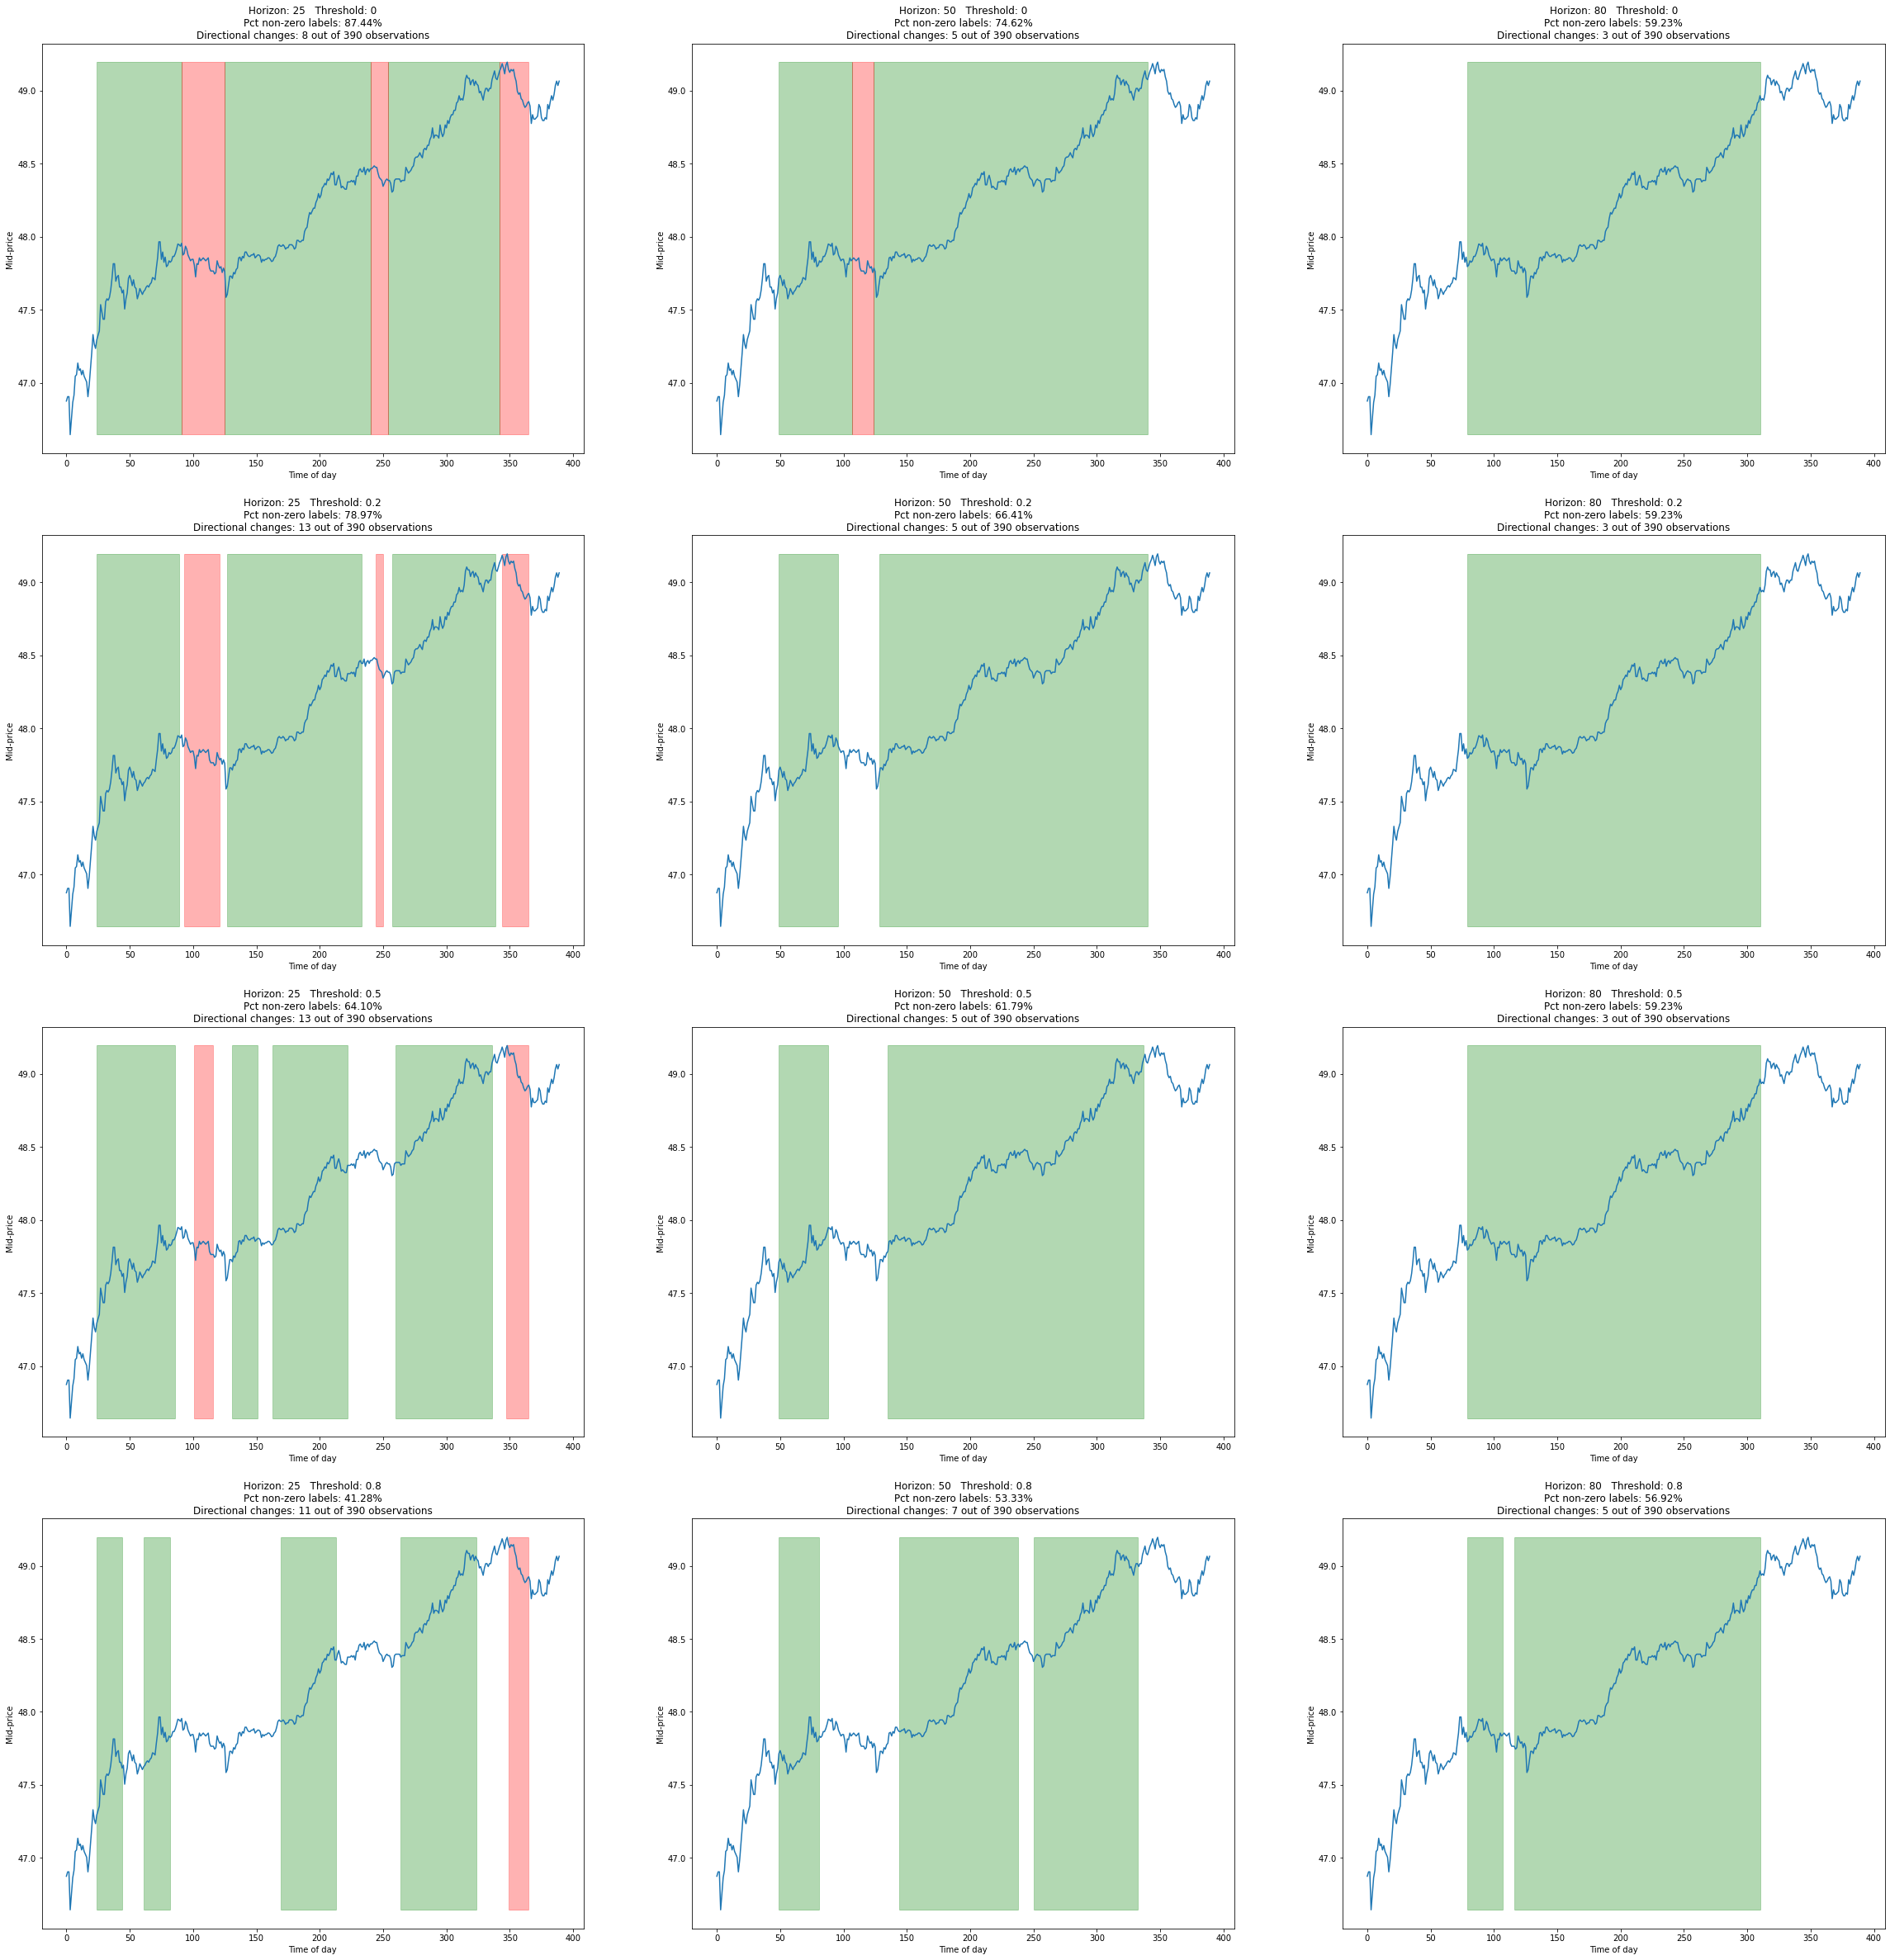

In [12]:
thresholds = [0, 0.2, 0.5, 0.8]
horizons = [25, 50, 80]
colors = ['red', 'white', 'green']

time = pd.Series(data.index)
mid_price = data.reset_index(drop=True).loc[pd.Series(data.index).dt.dayofyear == 2, 'mid_price']

fig = plt.figure(figsize=(len(thresholds) * 10, len(horizons * 14)))
i = 1
for threshold in thresholds:
    for horizon in horizons:
        directions = get_label(mid_price, horizon, threshold = threshold)

        ax = fig.add_subplot(len(thresholds), len(horizons), i)
        ax.set_xlabel("Time of day")
        ax.set_ylabel("Mid-price")
        ax.set_title(f"Horizon: {horizon}   Threshold: {threshold}\nPct non-zero labels: {(directions != 0).mean() * 100:.2f}%\nDirectional changes: {(directions != directions.shift(1)).sum()} out of {directions.shape[0]} observations")

        mid_price.plot(ax = ax)
        ax.fill_between(range(directions.shape[0]), mid_price.min(), mid_price.max(), where=(directions > 0) | (directions.shift(1) > 0), color = "green", alpha = 0.3)
        ax.fill_between(range(directions.shape[0]), mid_price.min(), mid_price.max(), where=(directions < 0) | (directions.shift(1) < 0), color = "red", alpha = 0.3)
        ax.fill_between(range(directions.shape[0]), mid_price.min(), mid_price.max(), where=(directions == 0) | (directions.shift(1) == 0), color = "white", alpha = 0.1)
        i += 1

#### Threshold
The threshold controls for noise by labelling uncertain signals as $0$ labels.  
Certainty is defined by how large the average movement is compared to the standard deviation of all such movements in the dataset.  

While we want to remove noise, we also want a somewhat balanced dataset.  
This is as, on one hand it is reasonable to claim that generally asset prices do not remain stationary, hence we do not want the majority of our labels to be 0.  
On the other hand, asset price movements comprise of a lot of noise and so the majority of movements should not be treated as directional signals.  
In the absence of quantitative evidence for the true class balance of signals in asset price movements, we'll compromise by using a balanced dataset, which also benefits our machine learning classifiers.  

The function `label_eval` is a 1-D function that returns the smallest class label proportion in the generated labels for a given threshold.  
We use the `scipy.optimize.minimize_scalar` function to find the optimal threshold value so that class labels are balanced.  

*Threshold is the multiplicative factor applied to the standard deviation of raw label magnitudes in the dataset that determines the threshold for the resulting label*


In [13]:
"""
For optimizing the threshold value to produce balanced class labels.

Use with scipy.optimize.minimize_scalar
"""
def label_eval(threshold, time_horizon = 50):
    labels = get_label(data.mid_price, time_horizon = time_horizon, threshold = threshold)
    counts = labels.value_counts()
    return -(counts / counts.sum()).min()

In [14]:
threshold = minimize_scalar(label_eval, bounds=(0, 2)).x
threshold  # The threshold value that gives the most balanced class distribution

0.2533227158388941

#### Time horizon
What the following statistics shows us are how frequently the label (which acts as our supervisory signal) changes direction.  
By using signals that exist for reasonably long durations, we can afford to squeeze model retraining into the earlier half of each window (as soon as the agent detects that the signal has changed) and then execute trades on whatever duration remains.

Therefore, signal windows should be large enough for the following:
- For the agent to detect that the signal has changed (Signal labels are -1, 0, or 1)
- Fine-tuning (training) the necessary weights
- Actual trades to be made after both the above points, while the signal is still effective

#### Generate Labels (Y)

The following describes the statistics for the average duration (in seconds) between changes in trading position:
count      140.000000
mean      2673.428571
std       2296.437583
min         60.000000
25%       1005.000000
50%       1860.000000
75%       3900.000000
max      11820.000000
Name: time, dtype: float64


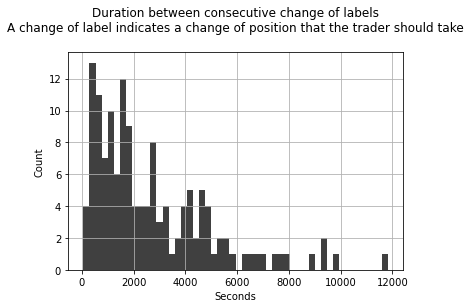

In [15]:
labels = get_label(data.mid_price, time_horizon=50, threshold=threshold)
changes = (labels != labels.shift(1))
time = pd.Series(changes.index)

time_between_trades = pd.Series(changes.loc[changes].index).diff().dt.total_seconds()
time_between_trades = time_between_trades.loc[time_between_trades < (17.5 * 3600)] # Ignore differences that have duration >= 4pm to 9:30am the next day
time_between_trades.hist(bins=50, color='black', alpha=0.75)
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.title("Duration between consecutive change of labels\nA change of label indicates a change of position that the trader should take\n")

print("The following describes the statistics for the average duration (in seconds) between changes in trading position:")
print(time_between_trades.describe());

# Not using changes.sum() / number of days that changes spans since this wouldnt filter for a position from 4pm to 930am

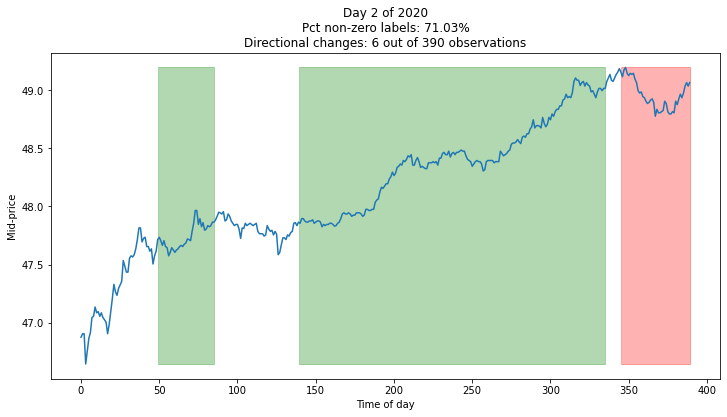

In [16]:
DAY_OF_YEAR = 2 # 2nd January 2020
_mid_price = data.reset_index(drop=True).loc[pd.Series(data.index).dt.dayofyear == DAY_OF_YEAR, 'mid_price']
_labels = labels.reset_index(drop=True).loc[pd.Series(data.index).dt.dayofyear == DAY_OF_YEAR]

fig = plt.figure(figsize=(12,6))
plt.xlabel("Time of day")
plt.ylabel("Mid-price")
plt.title(f"Day {DAY_OF_YEAR} of 2020\nPct non-zero labels: {(_labels != 0).mean() * 100:.2f}%\nDirectional changes: {(_labels != _labels.shift(1)).sum()} out of {_labels.shape[0]} observations")

_mid_price.plot()
plt.fill_between(range(_mid_price.shape[0]), _mid_price.min(), _mid_price.max(), where=(_labels > 0) | (_labels.shift(1) > 0), color = "green", alpha = 0.3)
plt.fill_between(range(_mid_price.shape[0]), _mid_price.min(), _mid_price.max(), where=(_labels < 0) | (_labels.shift(1) < 0), color = "red", alpha = 0.3)
plt.fill_between(range(_mid_price.shape[0]), _mid_price.min(), _mid_price.max(), where=(_labels == 0) | (_labels.shift(1) == 0), color = "white", alpha = 0.1);

### Standardize input data using a rolling window of past samples

Drop NA's from both inputs and labels after.

**Normalize AFTER generating the labels**

### Normalizer
---
- Computes rolling normalized values (I.e. Uses k previous values to normalize the next value)
- This is different from a walk-forward normalization where the 1st data point is always involved in the normalization of every other data point

In [17]:
"""
Note: Normalize AFTER generating the labels

Labels reflect the reality that we want to predict.
Normalization scales everything to relative terms, removing trends in the data.
"""
def rolling_normalize(data, window = 20):
    roll = data.rolling(window)
    result = (data - roll.mean()) / roll.std()
    return result

In [18]:
# interval_data = pd.concat([rolling_normalize(interval_data), labels], axis=1).dropna().reset_index(drop=True)

### Time series sampler

Function to sample consecutive time series data and a label

Things to consider before creating time series samples:
- Reindexing (Optional)
- Normalization (Optional)
- Consider implementing a function that reduces the bit-usage of the dtypes present, while maintaining accuracy. Do this before sampling the data. (Check if dtype bit count matters to the models)

Note that any row with NAs will be dropped.  


In [19]:
def is_same_day(array):
    series = pd.Series(array)
    if not issubclass(series.dtype.__class__, np.dtype('datetime64').__class__):
        raise TypeError(f"Function is_same_day was called on array of class {series.dtype.__class__} instead of {np.dtype('datetime64').__class__}")
    return (series.dt.day == series.dt.day.iloc[0]).all()

def generate_time_series_samples(data, labels, sample_size):
    # Verify index of time column
    # Labels, bid, ask (with time)
    na_idx = data.isna().any(axis=1) | labels.isna()
    
    data = data[~na_idx].reset_index()  # Data has time as its index, use it as a column
    labels = labels[~na_idx]
    
    # Save original info for later reuse
    columns = data.columns
    time_idx = columns.get_loc('time')  # Raises key error if not found
    
    samples = sliding_window_view(data, sample_size, axis=0).transpose((0, 2, 1))  # Outputs: (Batch, Observation, Column)
    sample_labels = labels.iloc[ (sample_size-1) : ]                               # Labels corresponding to `samples`
    
    same_day_mask = np.apply_along_axis(is_same_day, axis=1, arr=samples[:, :, time_idx])
    non_time_mask = np.arange(samples.shape[-1]) != time_idx
    samples = samples[same_day_mask, :, :][:, :, non_time_mask]  # Filter for data from the same day, and exclude the time column
    sample_labels = sample_labels[same_day_mask]                 # Labels corresponding to `samples`
    
    return samples.copy(), sample_labels.copy()

In [20]:
X, y = generate_time_series_samples(data, labels, 20)

In [21]:
bids = data.loc[y.index, 'bid'].copy()
asks = data.loc[y.index, 'ask'].copy()

## 4. Performance evaluator

### Performance metrics
- Can short toggle


In [22]:
"""
Evaluates the performance of a given strategy.
Ends by closing the last position that we took.

Assumes shorting is possible.

Bid: The bid price at the start of each interval
Ask: The ask price at the start of each interval
Position is a list or array:
  1  = BUY
  0  = EXIT
  -1 = SELL
"""
def evaluate_performance(bids, asks, signals, trading_fee = 0.001):
    not_same_shape = (signals.shape != asks.shape) or (signals.shape != bids.shape)
    if not_same_shape:
        raise ValueError(f"The arguments provided do not have matching shapes")
    
    has_timeindex_bids = issubclass(bids.index.__class__, pd.core.indexes.datetimes.DatetimeIndex)
    has_timeindex_asks = issubclass(asks.index.__class__, pd.core.indexes.datetimes.DatetimeIndex)
    if (bids.index != asks.index).any() or not (has_timeindex_bids and has_timeindex_asks):
        raise ValueError(f"The bids and asks arrays provided do not have matching time-series indexes")
    
    if not issubclass(signals.__class__, pd.Series):
        signals = pd.Series(signals, index=bids.index)
    
    if not issubclass(signals.index.__class__, pd.core.indexes.datetimes.DatetimeIndex) or (signals.index != asks.index).any():
        raise ValueError(f"The signals array provided does not have matching time-series indexes with the bids and asks time-series arrays provided")
        
    if bids.isna().any() or asks.isna().any() or signals.isna().any():
        raise ValueError(f"The arguments provided should not contain any NA values")
        
    timestamps = pd.Series(signals.index)

    # Signal: Do not hold positions overnight
    end_of_day_timestamps = timestamps.groupby([timestamps.dt.year, timestamps.dt.dayofyear]).max().reset_index(drop=True)
    signals.loc[end_of_day_timestamps] = 0

    # Signal: Identify the signal changes
    signal_change_mask = signals != signals.shift(1)     # First value True by default since not equal to NA
    signal_change_mask.iloc[0] = signals.iloc[0] != 0    # Set first value to True if given a signal

    # Position: Movements required
    signal_next = signals.loc[signal_change_mask]
    
    if signal_change_mask.iloc[0]:
        signal_prev = pd.Series(signals.loc[signal_change_mask.shift(-1).fillna(False)].values, index=signal_next.index[1:])
    else:
        signal_prev = pd.Series(signals.loc[signal_change_mask.shift(-1).fillna(False)].values, index=signal_next.index)
        
    movements = signals.copy() * 0
    movements.loc[signal_next.index] = (signal_next - signal_prev).fillna(signals.iloc[0])
    
    # Movements can only be -2, -1, 0, 1, 2
    assert movements.isin([-2, -1, 0, 1, 2]).all()
    
    # Movements should be net neutral, starting and ending with no assets
    assert movements.sum() == 0
    
    # Profit: Bid-ask spread
    buy_costs = -1 * (asks * movements.loc[movements > 0]).dropna()
    sell_profits = (bids * movements.loc[movements < 0].abs()).dropna()
    profit = sell_profits.sum() + buy_costs.sum()
    
    # Profit: Bid-ask spread cumulative
    profit_cumulative = movements.copy() * 0
    profit_cumulative.loc[buy_costs.index] = buy_costs
    profit_cumulative.loc[sell_profits.index] = sell_profits
    profit_cumulative = profit_cumulative.cumsum()
    
    # Profit: Mid-price
    mid_price = (asks + bids) / 2
    mid_buy_costs = -1 * (mid_price * movements.loc[movements > 0]).dropna()
    mid_sell_profits = (mid_price * movements.loc[movements < 0].abs()).dropna()
    profit_mid_price = mid_sell_profits.sum() + mid_buy_costs.sum()
    
    # Trading costs
    num_trades = movements.abs().sum()
    trading_costs = num_trades * trading_fee
    
    results = {
        'profit': profit,
        'profit_cumulative': profit_cumulative,
        'profit_mid_price': profit_mid_price,
        'trade_movements': movements,
        'trading_costs': trading_costs,
        'number_of_trades': num_trades.astype(int),
    }
    
    return results

def eval_performance(bids, asks, signals, plot_raw = False, fig_size = (8, 7), **kwargs):
    results = evaluate_performance(bids, asks, signals, **kwargs)
    print(f"Profit: {results['profit']}\nNumber of trades: {results['number_of_trades']}\nTrading costs: {results['trading_costs']}")
    
    cumu_profits = results['profit_cumulative']
    cumu_profits_index = cumu_profits.index.to_series()
    _end_of_day_profits = cumu_profits.groupby([cumu_profits_index.dt.year, cumu_profits_index.dt.dayofyear]).last().values
    _end_of_day_indexes = cumu_profits_index.groupby([cumu_profits_index.dt.year, cumu_profits_index.dt.dayofyear]).last().values
    end_of_day_profits = pd.Series(_end_of_day_profits, index=_end_of_day_indexes)
    
    end_of_day_profits.plot(color="black", marker='.', label="End of day balance", figsize=fig_size)
    if plot_raw:
        results['profit_cumulative'].plot(alpha=0.25, label="Intraday balance")
    plt.legend()
    plt.ylabel("Cumulative earnings")
    plt.title("Account balance as trading progressed");

## 5. Execution approaches

- Instantaneous model fine-tuning for now
- Explore any and all granularities without bias to more practical ones (that allow sufficient time for NN retraining)
- Usefulness of features [Simple models allow this]
- During training, monitor the training and validation loss to monitor for overfitting
- Consider progressing data w.r.t training duration of model to simulate real-time training. [LATER - Start with instantaneous training]

Things to explore:
- Toggle normalization
- Toggle reindexing with forward padding
- Granularities
- Time horizon

# To do:

- TimeSeriesSplit walk-forward ML
- Toggles
- Simple RL
- Plan Complex RL


Notes:
- When the prediction accuracy goes down, the profits can still go up. This shows that model architecture is more important than accuracy.
- How do we then integrate this prioritization of profits over accuracy into RL?

In [23]:
def _data_split(X, y, n_splits):
    inc = X.shape[0] // n_splits
    start_idx = 0
    end_idx = inc
    for i in range(n_splits):
        _X = X[start_idx:end_idx]
        _y = y[start_idx:end_idx]
        start_idx, end_idx = end_idx, end_idx + inc
        yield _X, _y

def time_series_split(X, y, model, n_splits=4, test_size=0.2, **kwargs):
    preds = []
    for _X, _y in _data_split(X, y, n_splits):
        X_train, X_test, y_train, y_test = train_test_split(_X, _y, shuffle=False, test_size=test_size) # Check that test_size travels through
        _model = model().fit(X_train, y_train)
        _preds = _model.predict(X_test)
        print(f"Accuracy: {(_preds == y_test).mean()}")
        preds.append(pd.Series(_preds, index=y_test.index))
    return pd.concat(preds)

### 5.1 Baseline model 0 - Using the known labels

Profit: 31.659999999999854
Number of trades: 194
Trading costs: 0.194


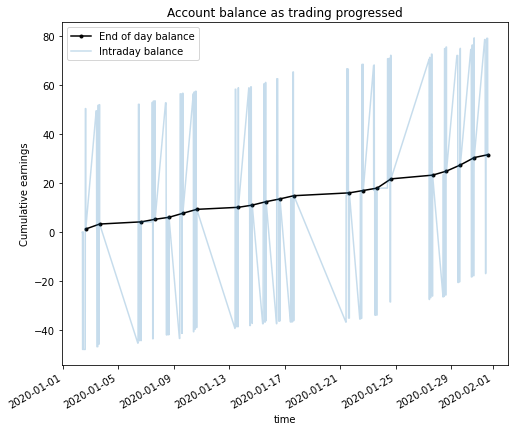

In [24]:
eval_performance(bids, asks, y, plot_raw = True)

### 5.2 Baseline model 1 - Long only

In [25]:
bm1_y = (y.copy() * 0 + 1)

Profit: 2.119999999999891
Number of trades: 42
Trading costs: 0.042


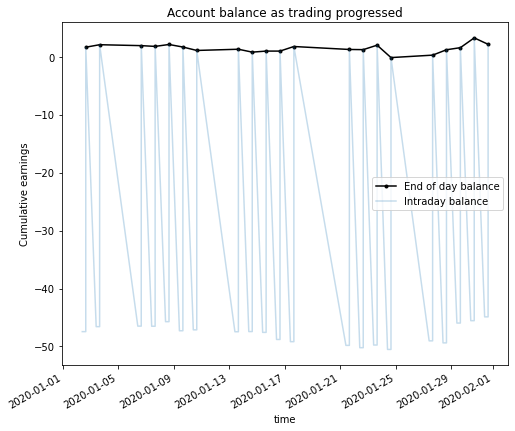

In [26]:
eval_performance(bids, asks, bm1_y, plot_raw = True)

In [27]:
data.reset_index().time.dt.day.nunique()

21

### 5.3 Logistic Regression

In [28]:
X_flat = X.reshape((X.shape[0], -1))
X_train, X_test, y_train, y_test, bids_train, bids_test, asks_train, asks_test = train_test_split(X_flat, y, bids, asks, shuffle=False, test_size=0.2)

In [29]:
lm1 = LogisticRegression(random_state=0, max_iter=8000).fit(X_train, y_train)
lm1_preds = lm1.predict(X_test)
print(f"Accuracy: {(lm1_preds == y_test).mean()}")

Accuracy: 0.5025641025641026


/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Profit: 1.7400000000002365
Number of trades: 138
Trading costs: 0.138


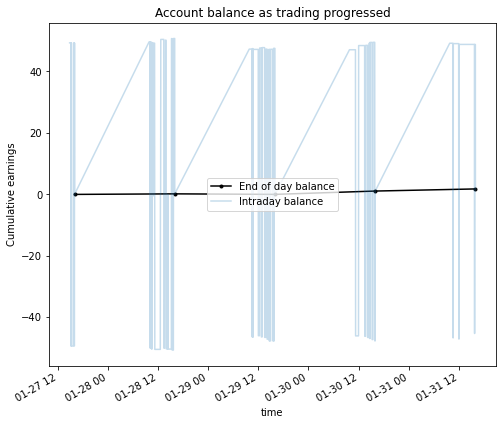

In [30]:
eval_performance(bids_test, asks_test, lm1_preds, plot_raw = True)

### 5.4 Discriminant Analysis

#### Linear Discriminant Analysis (LDA)

In [31]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_preds = lda.predict(X_test)
print(f"Accuracy: {(lda_preds == y_test).mean()}")

Accuracy: 0.44871794871794873


In [32]:
lda_preds.shape

(1560,)

Profit: 1.550000000000182
Number of trades: 86
Trading costs: 0.08600000000000001


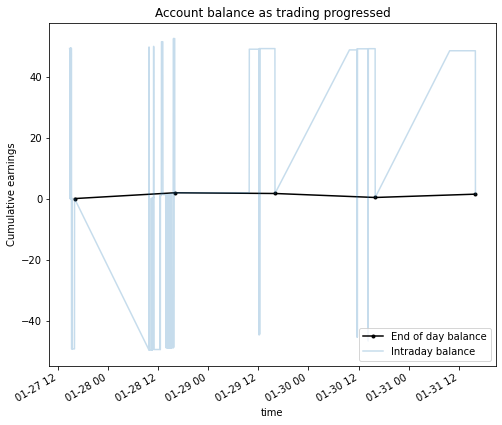

In [33]:
eval_performance(bids_test, asks_test, lda_preds, plot_raw = True)

In [34]:
lda_split_preds = time_series_split(X_flat, y, LinearDiscriminantAnalysis, n_splits = 3)

Accuracy: 0.5
Accuracy: 0.5173076923076924
Accuracy: 0.40576923076923077


In [35]:
lda_split_preds.shape

(1560,)

Profit: 3.209999999999127
Number of trades: 348
Trading costs: 0.34800000000000003


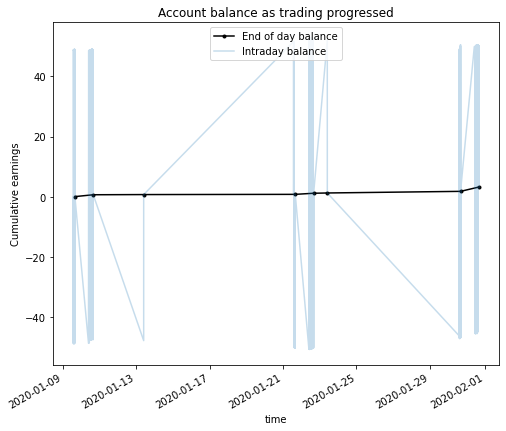

In [36]:
eval_performance(bids.loc[lda_split_preds.index], asks.loc[lda_split_preds.index], lda_split_preds, plot_raw = True)

#### Quadratic Discriminant Analysis (QDA)

In [37]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
qda_preds = qda.predict(X_test)
print(f"Accuracy: {(qda_preds == y_test).mean()}")

/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.2955128205128205


Profit: -3.809999999999718
Number of trades: 70
Trading costs: 0.07


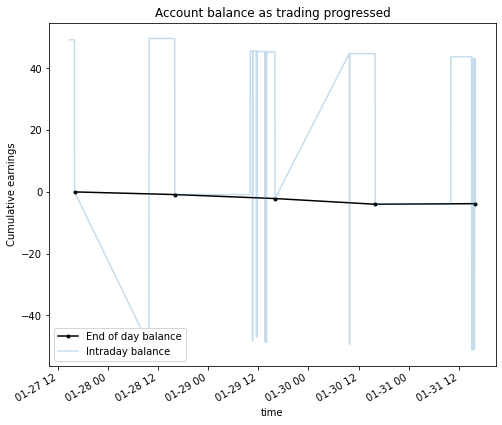

In [38]:
eval_performance(bids_test, asks_test, qda_preds, plot_raw = True)

In [39]:
qda_split_preds = time_series_split(X_flat, y, QuadraticDiscriminantAnalysis)

/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.12564102564102564


/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.3384615384615385


/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.06923076923076923


/home/e0310734/miniconda3/envs/rl_base/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.09743589743589744


In [40]:
qda_split_preds.shape

(1560,)

Profit: -3.6700000000009823
Number of trades: 222
Trading costs: 0.222


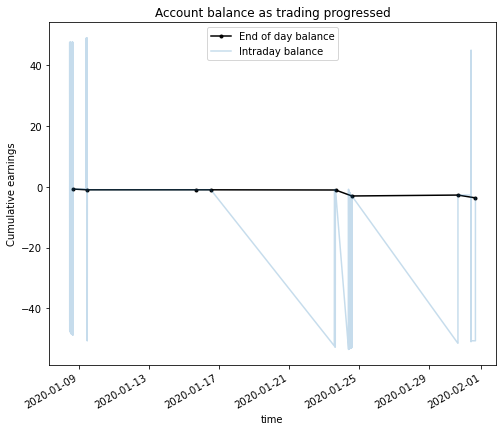

In [41]:
eval_performance(bids.loc[qda_split_preds.index], asks.loc[qda_split_preds.index], qda_split_preds, plot_raw = True)

### 5.5 K-Nearest Neighbours

In [42]:
neighbour_model = KNeighborsClassifier(n_neighbors=5)
neighbour_model.fit(X_train, y_train)
knn_preds = neighbour_model.predict(X_test)

Profit: -1.93000000000211
Number of trades: 494
Trading costs: 0.494


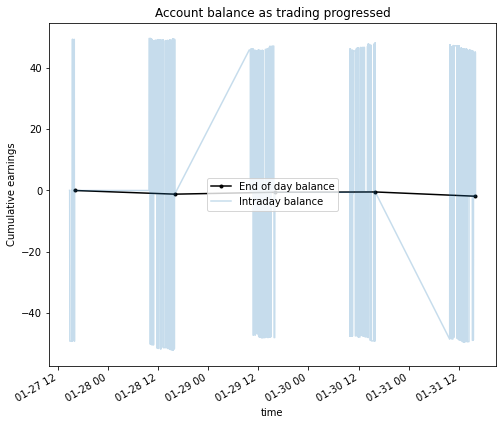

In [43]:
eval_performance(bids_test, asks_test, knn_preds, plot_raw = True)

### 5.6 Neural Network Multilayer Perceptron

#### NN MLP - 1 Hidden layer with 100 nodes

In [44]:
nn_mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
nn_mlp_preds = nn_mlp.predict(X_test)

In [45]:
(nn_mlp_preds == y_test).mean()

0.4596153846153846

Profit: -2.4900000000052387
Number of trades: 828
Trading costs: 0.8280000000000001


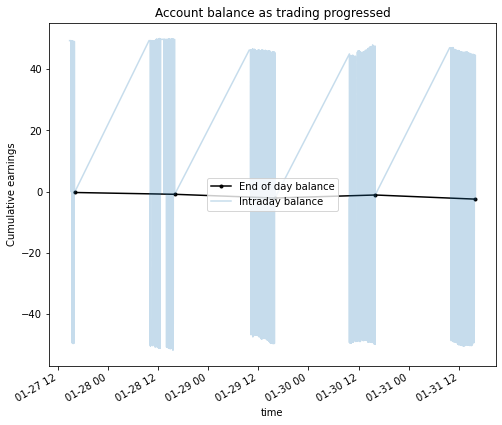

In [46]:
eval_performance(bids_test, asks_test, nn_mlp_preds, plot_raw = True)

#### NN MLP - 3 hidden layers with 20 nodes each

In [47]:
nn_mlp2 = MLPClassifier(hidden_layer_sizes = (128, 32, 16, 16), random_state=1, max_iter=1000).fit(X_train, y_train)
nn_mlp_preds2 = nn_mlp2.predict(X_test)

In [48]:
(nn_mlp_preds2 == y_test).mean()

0.4564102564102564

Profit: 1.110000000000582
Number of trades: 248
Trading costs: 0.248


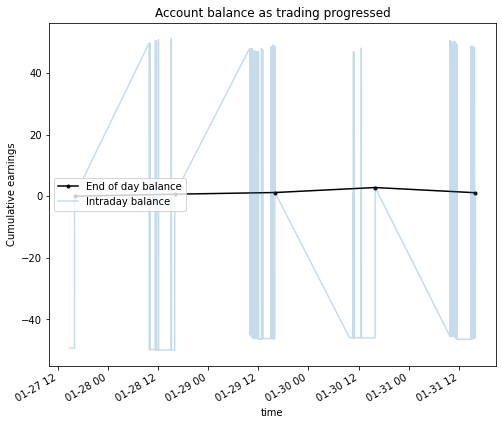

In [49]:
eval_performance(bids_test, asks_test, nn_mlp_preds2, plot_raw = True)

## 6. Reinforcement Learning

- Attempt policy gradient methods first, since policy decision space (Buy, Sell, Exit) are simpler than estimating the total future returns for a given state. [Thoughts: Actually, asset trading is an infinite game, so we cant really estimate long term returns]



The problems im having:
- Engineering wise, i need to refactor my code
  - Have a single notebook for each RL approach
  - Send all preprocessing functions to a package to be imported
- (State, action) representation
  - I have financial indicators, but what RL factors do I include in the state? Our current position?
  - Whats the difference between S and (S, A)?
  
- 